In [1]:
import numpy as np
from statsmodels import regression
from scipy.stats import shapiro
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.stats.diagnostic as smd
import scipy.optimize as optimize

In [199]:
def get_stock_tickers():
    url_spy = 'https://en.m.wikipedia.org/wiki/Nasdaq-100'
    url_qqq = 'https://en.m.wikipedia.org/wiki/List_of_S%26P_500_companies'
    spy =  pd.read_html(url_spy, attrs={'id': "constituents"}, index_col='Ticker')[0]
    qqq = pd.read_html(url_qqq, attrs={'id': 'constituents'}, index_col='Symbol')[0]
    spy = spy.index.to_list()
    qqq = qqq.index.to_list()
    stocks = spy + qqq
    stocks = list(set(stocks))
    stocks.sort()
    return stocks

tickers2 = get_stock_tickers()
start = "2015-01-01"
end = "2024-01-01"
data = yf.download(tickers2,start=start, end=end)


[*********************100%%**********************]  520 of 520 completed

2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2024-01-01)')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     2172.
Date:                Tue, 05 Mar 2024   Prob (F-statistic):          1.95e-253
Time:                        11:11:30   Log-Likelihood:                 2984.5
No. Observations:                1007   AIC:                            -5965.
Df Residuals:                    1005   BIC:                            -5955.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.754e-05      0.000     -0.247      0.805      -0.001       0.001
Close          0.9770      0.021     46.607      0.000       0.936       1.018
==============================================================================
Omnibus:                      163.518   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1691.679
Skew:                          -0.383   Prob(JB):                         0.00
Kurtosis:                       9.303   Cond. No.                         53.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

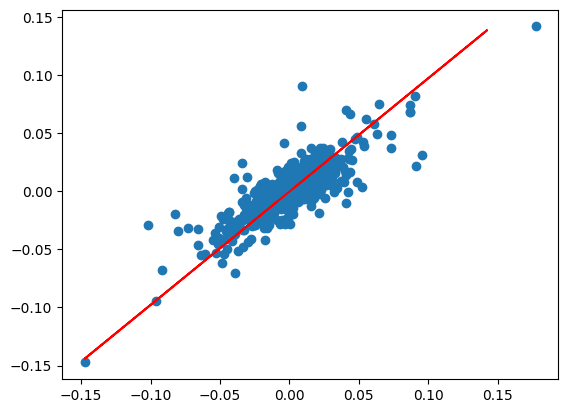

In [158]:
start = "2018-01-01"
end = "2022-01-01"
X = "MSFT"
y = "ADBE"
data = yf.download(X, start=start, end=end)["Close"]
asset = yf.download(y, start=start, end=end)["Close"]
asset = asset.pct_change()[1:]
data = data.pct_change()[1:]
model = sm.OLS(asset, sm.add_constant(data)).fit()
alpha, beta = model.params
reg_line = alpha + beta * data
plt.scatter(asset, data, alpha=1)
plt.plot(data, reg_line, "r")
model.summary()

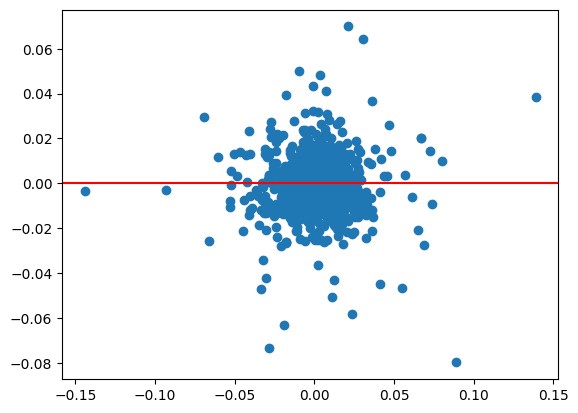

0.0021124559777931594
0.3803479494341656


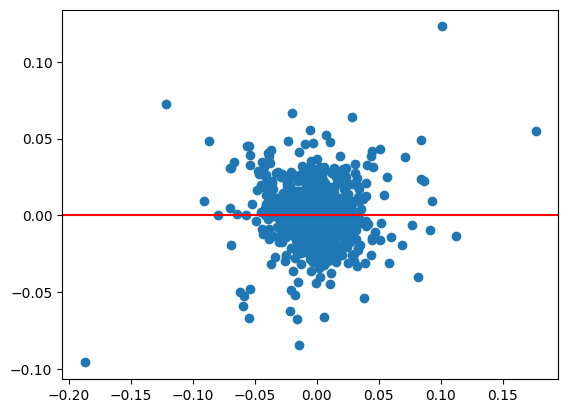

In [168]:
plt.scatter(model.predict(), model.resid)
plt.axhline(0, color="red")
plt.show()
heteroscedasticity = smd.het_breuschpagan(model.resid, model.model.exog)[1]
print(heteroscedasticity)
diff = np.diff(reg_line)
model_diff = sm.OLS(diff, sm.add_constant(data[1:])).fit()
heteroscedasticity_diff = smd.het_breuschpagan(diff, model_diff.model.exog)[1]
print(heteroscedasticity_diff)
plt.scatter(model_diff.predict(), model_diff.resid)
plt.axhline(0, color="red")

In [182]:
ljung_box = smd.acorr_ljungbox(asset, lags=20)
ljung_box

,lb_stat,lb_pvalue
1,66.793654,3.014670e-16
2,71.512715,2.959452e-16
3,71.544083,1.993309e-15
4,73.396245,4.350385e-15
5,73.399618,2.006604e-14
6,76.505207,1.879724e-14
7,89.582329,1.507348e-16
8,109.249635,5.430299e-20
9,130.899928,7.744007e-24
10,132.411978,1.503534e-23


In [30]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
data = pd.DataFrame([[2,4,7], [4,5,1], [7,1, 6], [8,4,4]])
corr_matrix = data.corr()
corr_matrix

,0,1,2
0,1.000000,-0.454257,-0.114377
1,-0.454257,1.000000,-0.581914
2,-0.114377,-0.581914,1.000000


In [31]:
distance_matrix = corr_matrix.apply(lambda x: np.sqrt(0.5 * (1 - x)))

In [32]:
distance_matrix

,0,1,2
0,0.000000,0.852718,0.746451
1,0.852718,0.000000,0.889358
2,0.746451,0.889358,0.000000


In [33]:
pairwise_distance = pdist(distance_matrix, metric="euclidean")
pairwise_distance

array([1.2143637 , 1.05627634, 1.2622231 ])

In [34]:
full_distance = squareform(pairwise_distance)
full_distance

array([[0.        , 1.2143637 , 1.05627634],
       [1.2143637 , 0.        , 1.2622231 ],
       [1.05627634, 1.2622231 , 0.        ]])

In [40]:
clusters = linkage(pairwise_distance, method="complete", metric="euclidean")
clusters2 = linkage(full_distance, method="complete", metric="euclidean")

C:\Users\Jan Süßmann\AppData\Local\Temp\ipykernel_60036\459033359.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters2 = linkage(full_distance, method="complete", metric="euclidean")


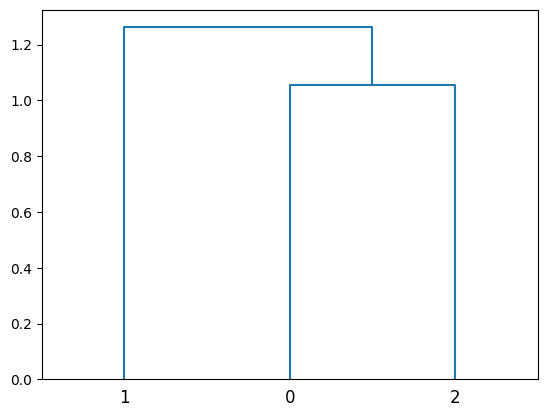

In [48]:
dendro = dendrogram(clusters)

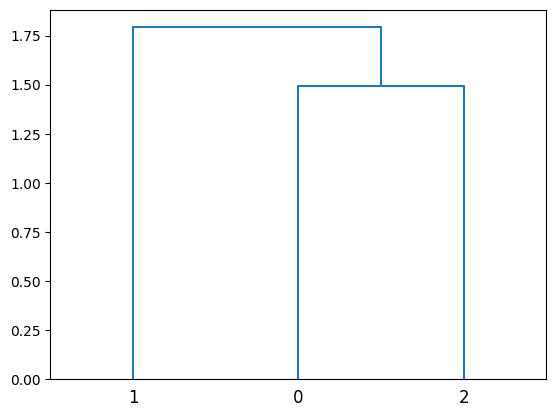

In [49]:
dendro2 = dendrogram(clusters2)